# Loading data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
directory = '/content/drive/MyDrive/MLDM_project_data/'

Uncomment if using for the first time

In [ ]:
# !pip install pyunpack
# !pip install patool

# from pyunpack.cli import Archive

# 
# Archive(directory + 'train.csv.7z').extractall(directory)
# Archive(directory + 'test.csv.7z').extractall(directory)
# Archive(directory + 'songs.csv.7z').extractall(directory)
# Archive(directory + 'members.csv.7z').extractall(directory)
# Archive(directory +'song_extra_info.csv.7z').extractall(directory)

In [ ]:
songs = pd.read_csv(directory + 'songs.csv', index_col='song_id')
members = pd.read_csv(directory  + 'members.csv', parse_dates=['registration_init_time', 'expiration_date'])
songs_extra = pd.read_csv(directory  + 'song_extra_info.csv', index_col='song_id')
train = pd.read_csv(directory + 'train.csv')
test = pd.read_csv(directory + 'test.csv')

# Feature engineering

## FE before merging

### FE for source... stuff

In [ ]:
print('Train\n', train['source_screen_name'].nunique(), train['source_screen_name'].unique())
print('Test\n', test['source_screen_name'].nunique(), test['source_screen_name'].unique())
print('Labels not presented in train\n', set(train['source_screen_name'].unique()) ^ set(test['source_screen_name'].unique()))

Train
 20 ['Explore' 'Local playlist more' nan 'My library' 'Online playlist more'
 'Album more' 'Discover Feature' 'Unknown' 'Discover Chart' 'Radio'
 'Artist more' 'Search' 'Others profile more' 'Search Trends'
 'Discover Genre' 'My library_Search' 'Search Home' 'Discover New'
 'Self profile more' 'Concert' 'Payment']
Test
 22 ['Local playlist more' nan 'Radio' 'Online playlist more' 'Artist more'
 'Discover Genre' 'Album more' 'Discover Chart' 'Discover Feature'
 'Search' 'Unknown' 'Explore' 'Others profile more' 'My library'
 'My library_Search' 'Search Trends' 'Discover New' 'Search Home'
 'Payment' 'Self profile more' 'People local' 'Concert' 'People global']
Labels not presented in train
 {'People global', 'People local'}


In [ ]:
def preprocess_source_data(df, test=False):
  # deal with capitalized letters
  df['source_screen_name'] = df['source_screen_name'].str.lower()
  # deal with nans
  for col in ['source_screen_name', 'source_system_tab', 'source_type']:
    df[col] = df[col].fillna('unknown')
  # deal with labels which are not presented in train
  if test:
    df['source_screen_name'].replace(['people local', 'people global'], 'unknown', inplace=True)
  return df

In [ ]:
train = preprocess_source_data(train)
test = preprocess_source_data(test, test=True)

### FE for user data

There is more then 40% of NaNs in Gender column of members dataframe, so let us define 2 different ways to treat this column:  
1. assign unknown to NaN value
2. assign random value to it  

Let us add also a column which tells us the amount of membership days of particular person.

In [ ]:
def preprocess_user_data(df, gender_rand=False):
  # transform gender to binary
  m = {'male' : 1, 'female' : 0}
  df['gender'] = df['gender'].map(m)
  # deal with nans in gender
  if gender_rand:
    a = df['gender'].values
    m = np.isnan(a) # mask of NaNs
    a[m] = np.random.choice(2, size=m.sum())
  else:
    df['gender'].fillna(2, inplace=True)

  # deal with expiration date 1970y, which is less then registration date
  df.loc[df['expiration_date']<df['registration_init_time'], 'expiration_date'] = df['expiration_date'].quantile(0.5, interpolation="midpoint")
  # add new column membership days
  df['membership_days'] = (df['expiration_date'] - df['registration_init_time']).dt.days.astype(int)

  # make birthdays (actually age) with less than 0 and more than 90 -> 0 (it means unspecified)
  to_remove = df.loc[(df['bd'] < 0) | (df['bd'] > 90), 'bd'].values
  df['bd'].replace(to_remove, 0, inplace=True)

  # add new binary column about "has age info or not" 
  cond = df['bd'] != 0
  df['got_bd'] = np.where(cond, 1, 0)
  
  return df

In [ ]:
members = preprocess_user_data(members, gender_rand=False)

In [ ]:
def expand_df(df, keys, ad_dfs):
  for k, ad_df in zip(keys, ad_dfs):
    df = df.merge(ad_df, how='left', on=k)
  return df

In [ ]:
keys = ['song_id', 'song_id', 'msno']
dfs = [songs, songs_extra, members]

train_expanded = expand_df(train, keys, dfs)
test_expanded = expand_df(test, keys, dfs)

#### User country

Let us try to understand which country user is from by the countries of the most popular music for city where is the user from.  
Wiki says that the KKBOX service mainly targets the music markets of East and Southeast Asia, focusing on regions including: Taiwan, Hong Kong, Malaysia, Japan and Singapore, so let us focus only on these countries.

In [ ]:
train_expanded['song_country'] = train_expanded['isrc'].str[:2]
test_expanded['song_country'] = test_expanded['isrc'].str[:2]

['GB' 'US' 'QM' 'TW' nan 'BE' 'AR' 'CN' 'HK' 'KR' 'JP' 'DE' 'CA' 'FR' 'IT'
 'NO' 'SE' 'NL' 'DK' 'MY' 'TC' 'SG' 'UK' 'EM' 'ES' 'GM' 'TG' 'CH' 'TE'
 'AU' 'GT' 'PL' 'BR' 'UA' 'GL' 'CY' 'RO' 'IE' 'TH' 'PT' 'NG' 'FI' 'IN'
 'QZ' 'MX' 'VG' 'MT' 'PH' 'NZ' 'TR' 'RU' 'EU' 'TM' 'BX' 'CB' 'CO' 'EG'
 'AT' 'AD' 'BG' 'ZA' 'ID' 'UG' 'GR' 'HR' 'MH' 'IL' 'HU' 'PR' 'JK' 'ZZ'
 'IS' 'WW' 'LB' 'MA' 'CZ' 'MO' 'KI' 'LV' 'NJ' 'DM' 'MK' 'AE' 'LU' 'CL'
 'GY' 'PE' 'IF' 'BZ' 'SK' 'TP' 'UD' 'SA' 'PY' 'BK' 'EE' 'LT' 'UY' 'JM'
 'UZ' 'SI' 'CM' 'OM' 'BY' 'GD' 'YW' 'RS' 'GN' 'IR' 'KE']


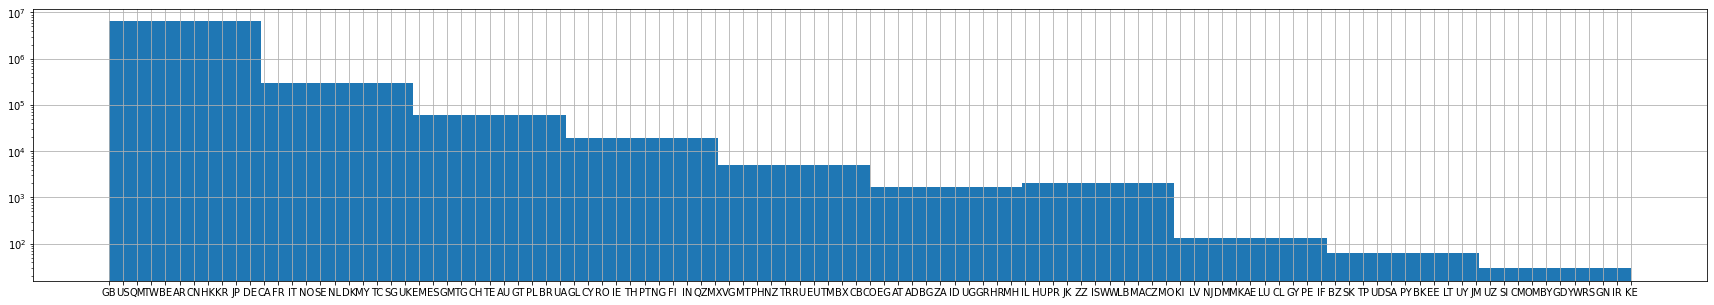

In [ ]:
print(train_expanded['song_country'].unique())
plt.figure(figsize=(30, 5))
train_expanded['song_country'].hist()
plt.yscale('log')
plt.show()

In [ ]:
print(train_expanded['city'].unique())
train_expanded.groupby('city')['city'].count().sort_values(ascending=False)

[ 1 13 15  5  9 21 22 12  4  6 14 17 10  8 11 18  3  7 20 16 19]


city
1     2621293
13    1144863
5      830128
4      545820
15     484078
22     460330
6      275781
14     236639
12     147133
9       95237
8       85734
18      81780
11      71542
10      69158
21      67097
3       63555
17      44688
7       31621
16       7887
19       6961
20       6093
Name: city, dtype: int64

In [ ]:
for city in train_expanded.city.unique():
  print(city)
  top_countries = train_expanded[train_expanded.city == city].groupby('song_country')['song_country'].count().sort_values(ascending=False)[:5]
  print(top_countries)

1
song_country
TW    1230776
US     438629
GB     144910
KR     136895
HK     126121
Name: song_country, dtype: int64
13
song_country
TW    574854
US    184066
HK     58119
GB     57880
KR     57795
Name: song_country, dtype: int64
15
song_country
TW    246223
US     76605
HK     24867
GB     24430
KR     22013
Name: song_country, dtype: int64
5
song_country
TW    380968
US    156196
GB     53079
KR     40531
HK     40074
Name: song_country, dtype: int64
9
song_country
TW    47174
US    15486
GB     4992
HK     4903
KR     4814
Name: song_country, dtype: int64
21
song_country
TW    34015
US    11158
KR     3545
GB     3334
HK     2989
Name: song_country, dtype: int64
22
song_country
TW    231013
US     70881
GB     23281
HK     22506
KR     20090
Name: song_country, dtype: int64
12
song_country
TW    74167
US    21981
KR     7497
GB     7399
HK     7049
Name: song_country, dtype: int64
4
song_country
TW    274985
US     84498
GB     27701
HK     27023
KR     25285
Name: song_country, d

So, there is no meaningful information to extract, mostly all users listen to Taiwan songs

### FE Train Info

In [ ]:
def preprocess_main_info(df, test=False, train_df=None):
  # count how many songs did user listened
  df = df.merge(df.groupby('msno')['msno'].count(), 
                left_on='msno', 
                right_index=True, 
                how='left', 
                suffixes=('', '_1'))
  # song popularity by all plays
  df = df.merge(df.groupby('song_id')['song_id'].count(), 
                left_on='song_id', 
                right_index=True, 
                how='left', 
                suffixes=('', '_2'))
  
  df = df.rename(columns={'msno_1':'user_plays',
                          'song_id_2':'song_plays'})
  if not test:
    # target based features 
    # if user tends to repeat the music he listens to
    df = df.merge(df.groupby('msno')['target'].sum(), 
                  left_on='msno', 
                  right_index=True, 
                  how='left', 
                  suffixes=('', '_3'))
    # song popularity by repeats
    df = df.merge(df.groupby('song_id')['target'].sum(), 
                  left_on='song_id', 
                  right_index=True, 
                  how='left', 
                  suffixes=('', '_4'))
        
    df = df.rename(columns={'target_3':'user_repeats',
                            'target_4':'song_repeats'})
    
    df['user_repeat_ratio'] = df['user_repeats']/df['user_plays']
    df['song_repeat_ratio'] = df['song_repeats']/df['song_plays']

  else:
    # if user tends to repeat the music he listens to
    test_list = set(train_df['msno']).intersection(df['msno'])
    test_dict = train_df.loc[train_df['msno'].isin(test_list)][['msno', 'user_repeat_ratio']].set_index('msno').to_dict()
    df['user_repeat_ratio'] = df['msno'].map(test_dict['user_repeat_ratio'])
    # song popularity by repeats
    test_list = set(train_df['song_id']).intersection(df['song_id'])
    test_dict = train_df.loc[train_df['song_id'].isin(test_list)][['song_id', 'song_repeat_ratio']].set_index('song_id').to_dict()
    df['song_repeat_ratio'] = df['song_id'].map(test_dict['song_repeat_ratio'])
    df.drop('id', axis=1, inplace=True)
  return df

In [ ]:
train = preprocess_main_info(train)
test = preprocess_main_info(test, True, train)

### FE songs info

Derive years on decades 

In [ ]:
songs_extra['year'] = songs_extra['isrc'].str[5:7]
songs_extra['year'] = songs_extra['year'].fillna(-1).apply(int)
songs_extra['year'] = np.where(((songs_extra['year'] > 0) & (songs_extra['year'] > 17)), songs_extra['year'] + 1900, songs_extra['year'] + 2000)
songs_extra['decade'] = songs_extra['year'] // 10 * 10
songs_extra['country'] = songs_extra['isrc'].str[:2]

Percent of nan data in songs dataset

In [ ]:
def nan_percent(df):
    return df.isna().sum() * 100 /df.shape[0]

In [ ]:
nan_percent(songs)

song_length     0.000000
genre_ids       4.098558
artist_name     0.000000
composer       46.655257
lyricist       84.712409
language        0.000044
dtype: float64

Let's fill genre and language NaNs as most popular genres for the specific artist. Other values as UNKNOWN

In [ ]:
df_most_common = songs[['genre_ids', 'language', 'artist_name']].groupby('artist_name').agg(pd.Series.mode)
df_most_common = df_most_common[~df_most_common.index.duplicated(keep='first')].reset_index()
df_most_common.columns = ['artist_name','genre_pop', 'language_pop']

In [ ]:
df_most_common['genre_pop']= np.where(df_most_common['genre_pop'].apply(lambda x: isinstance(x, np.ndarray)), df_most_common['genre_pop'].str.join('|'), df_most_common['genre_pop'])
df_most_common['genre_pop']= np.where(df_most_common['genre_pop'] == '', 'UNKNOWN', df_most_common['genre_pop'])

In [ ]:
songs_pop = songs.reset_index().merge(df_most_common, how='left', on='artist_name')
songs_pop['genre_ids'] = songs_pop['genre_ids'].fillna(songs_pop['genre_pop']) 
songs_pop['language'] = songs_pop['language'].fillna(songs_pop['language_pop'])
songs_pop = songs_pop.fillna('UNKNOWN')
songs = songs_pop.set_index('song_id')[['song_length', 'artist_name', 'composer', 'lyricist', 'language','genre_ids']]
songs['genre_list'] = songs['genre_ids'].str.split('|')

Let's look on dictibution of song length in train data

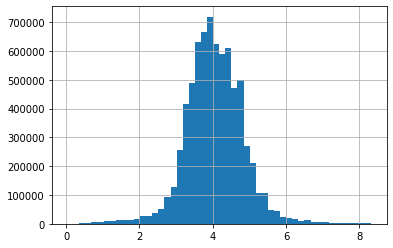

In [ ]:
train_song = train.set_index('song_id').join(songs)
(train_song.loc[train_song.song_length < 500000]['song_length'] / 60000).hist(bins=50)

The usual song length are in interval [2.5, 5.5] minutes.

The other right side of the data on histogram is just decreasing tail. So, let's just random divide song length on following intervals:

0. [0, 2.5]
1. [2.5, 5.5]
2. [5.5, 10]
3. [10, 30]
4. [30, 60]
5. \>60 
minutes

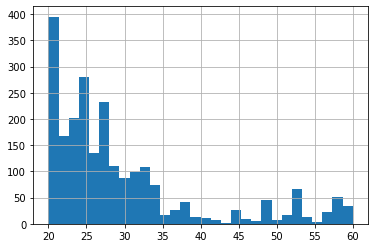

In [ ]:
(train_song.loc[(train_song.song_length > 20 * 60000) & 
                (train_song.song_length < 60 * 60000)]['song_length'] / 60000).hist(bins=30)

In [ ]:
condlist = [songs['song_length'] < 2.5*60000,
            (songs['song_length']>=2.5*60000) & (songs['song_length'] < 5.5 * 60000), 
            (songs['song_length'] >= 5.5 * 60000) & (songs['song_length'] < 10 * 60000),
            (songs['song_length'] >= 10 * 60000) & (songs['song_length'] < 30 * 60000), 
            (songs['song_length'] >= 30 * 60000) & (songs['song_length'] < 60 * 60000),
            songs['song_length'] >= 60 * 60000]
choicelist = list(range(0, len(condlist)))
songs['song_length_cat'] = np.select(condlist, choicelist)

In [ ]:
artists_num = songs.artist_name.str.split('|')
len_artists_num = [len(x) for x in list(artists_num) if len(x) != 1 and len(x) <50]

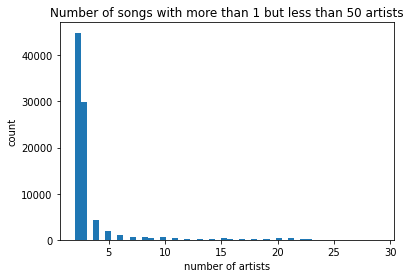

In [ ]:
from matplotlib import pyplot as plt

data = len_artists_num

plt.hist(data, bins=50)
plt.title('Number of songs with more than 1 but less than 50 artists')
plt.xlabel('number of artists')
plt.ylabel('count')

plt.show()

In [ ]:
def count_series_elements(df, column_name):
    df[column_name+'_number'] = df[column_name].str.count(r'\|') + 1
    df.loc[df[column_name] == 'UNKNOWN', column_name+'_number'] = 0

In [ ]:
count_series_elements(songs, 'artist_name')
count_series_elements(songs, 'composer')
count_series_elements(songs, 'lyricist')
songs['genre_number'] = songs['genre_list'].str.len()
songs = songs.drop(['genre_list'], axis=1)

In [ ]:
nan_percent(songs_extra)

name       0.000087
isrc       5.947288
year       0.000000
decade     0.000000
country    5.947288
dtype: float64

In [ ]:
songs_all = songs.join(songs_extra)

In [ ]:
nan_percent(songs_all)

song_length           0.000000
artist_name           0.000000
composer              0.000000
lyricist              0.000000
language              0.000000
genre_ids             0.000000
song_length_cat       0.000000
artist_name_number    0.000000
composer_number       0.000000
lyricist_number       0.000000
genre_number          0.000000
name                  0.039193
isrc                  5.984706
year                  0.039106
decade                0.039106
country               5.984706
dtype: float64

Let's get rid of nan values in "decade" and "country" by choosing the most common decades and countries in artist's name

In [ ]:
df_most_common = songs_all[['decade', 'country', 'artist_name']].groupby('artist_name').agg(pd.Series.mode)
df_most_common = df_most_common[~df_most_common.index.duplicated(keep='first')].reset_index()
df_most_common.columns = ['artist_name','decade_pop', 'country_pop']

In [ ]:
songs_pop = songs_all.reset_index().merge(df_most_common, how='left', on='artist_name')
songs_pop['decade'] = songs_pop['decade'].fillna(songs_pop['decade_pop']) 
songs_pop['country'] = songs_pop['country'].fillna(songs_pop['country_pop'])
songs_pop = songs_pop.fillna('UNKNOWN')

In [ ]:
songs_all = songs_pop.set_index('song_id')[['artist_name','composer', 'lyricist', 'language', 'genre_ids', 
                                            'song_length_cat', 'artist_name_number', 'composer_number', 'lyricist_number', 
                                            'genre_number', 'name', 'decade', 'country']]

In [ ]:
songs_all

,artist_name,composer,lyricist,language,genre_ids,song_length_cat,artist_name_number,composer_number,lyricist_number,genre_number,name,decade,country
song_id,,,,,,,,,,,,,
CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,張信哲 (Jeff Chang),董貞,何啟弘,3.0,465,1,1,1,1,1,焚情,2010,TW
o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0,444,1,1,3,1,1,PLAYING WITH FIRE,1990,TW
DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,SUPER JUNIOR,UNKNOWN,UNKNOWN,31.0,465,1,1,0,0,1,SORRY| SORRY,1990,KR
dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,S.H.E,湯小康,徐世珍,3.0,465,1,1,1,1,1,愛我的資格,2000,TW
W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,貴族精選,Traditional,Traditional,52.0,726,0,1,1,1,1,Mary Had a Little Lamb,1990,GB
...,...,...,...,...,...,...,...,...,...,...,...,...,...
lg6rn7eV/ZNg0+P+x77kHUL7GDMfoL4eMtXxncseLNA=,Catherine Collard,Robert Schumann (1810-1856),UNKNOWN,-1.0,958,0,1,1,0,1,Schumann: Papillons| Op. 2: II. Prestissimo,1970,FR
nXi1lrSJe+gLoTTNky7If0mNPrIyCQCLwagwR6XopGU=,紀文惠 (Justine Chi),UNKNOWN,UNKNOWN,3.0,465,1,1,0,0,1,怎麼啦,2010,TW
9KxSvIjbJyJzfEVWnkMbgR6dyn6d54ot0N5FKyKqii8=,Various Artists,UNKNOWN,UNKNOWN,52.0,1609,2,1,0,0,1,Still Here,2010,DE


### Final songs data

In [ ]:
songs_all = pd.read_csv(directory + 'songs_all.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Merging member's data with train and test

Merging all data for train and test

In [ ]:
def expand_df(df, keys, ad_dfs):
  for k, ad_df in zip(keys, ad_dfs):
    df = df.merge(ad_df, how='left', on=k)
  return df

In [ ]:
keys = ['song_id', 'song_id', 'msno']
dfs = [songs, songs_extra, members]

train_expanded = expand_df(train, keys, dfs)
test_expanded = expand_df(test, keys, dfs)

In [ ]:
train_expanded.isna().sum()/train_expanded.shape[0]

msno                      0.000000
song_id                   0.000000
source_system_tab         0.000000
source_screen_name        0.000000
source_type               0.000000
target                    0.000000
user_plays                0.000000
song_plays                0.000000
user_repeats              0.000000
song_repeats              0.000000
user_repeat_ratio         0.000000
song_repeat_ratio         0.000000
song_length               0.000015
genre_ids                 0.016056
artist_name               0.000015
composer                  0.227140
lyricist                  0.430882
language                  0.000020
name                      0.000197
isrc                      0.078328
city                      0.000000
bd                        0.000000
gender                    0.000000
registered_via            0.000000
registration_init_time    0.000000
expiration_date           0.000000
membership_days           0.000000
got_bd                    0.000000
dtype: float64

In [ ]:
test_expanded.isna().sum()/test_expanded.shape[0]

msno                      0.000000
song_id                   0.000000
source_system_tab         0.000000
source_screen_name        0.000000
source_type               0.000000
user_plays                0.000000
song_plays                0.000000
user_repeat_ratio         0.071972
song_repeat_ratio         0.125206
song_length               0.000010
genre_ids                 0.016470
artist_name               0.000010
composer                  0.242219
lyricist                  0.479016
language                  0.000016
name                      0.000304
isrc                      0.076910
city                      0.000000
bd                        0.000000
gender                    0.000000
registered_via            0.000000
registration_init_time    0.000000
expiration_date           0.000000
membership_days           0.000000
got_bd                    0.000000
dtype: float64

In [ ]:
# saving all previous dataframes cause it crashed when I merged so tremendous dataframes
train_expanded.to_csv(directory + 'train_expanded.csv', index=False)
test_expanded.to_csv(directory + 'test_expanded.csv', index=False)

In [ ]:
# read previous dataframes
train_expanded = pd.read_csv(directory + 'train_expanded.csv', parse_dates=['registration_init_time', 'expiration_date'])
test_expanded = pd.read_csv(directory + 'test_expanded.csv', parse_dates=['registration_init_time', 'expiration_date'])

In [ ]:
# example of dataframe
test_expanded

,song_id,artist_name,composer,lyricist,language,genre_ids,song_length_cat,artist_name_number,composer_number,lyricist_number,genre_number,name,decade,country
0,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,梁文音 (Rachel Liang),Qi Zheng Zhang,UNKNOWN,3.0,458,1.0,1.0,1.0,0.0,1.0,愛其實很殘忍,2010,TW
1,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,林俊傑 (JJ Lin),林俊傑,孫燕姿/易家揚,3.0,465,1.0,1.0,1.0,1.0,1.0,她說,2010,TW
2,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,Yu Takahashi (高橋優),Yu Takahashi,Yu Takahashi,17.0,2022,1.0,1.0,1.0,1.0,1.0,subarashiki nichijo,2010,JP
3,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,U2,The Edge| Adam Clayton| Larry Mullen| Jr.,UNKNOWN,52.0,465,1.0,1.0,4.0,0.0,1.0,Hold Me| Thrill Me| Kiss Me| Kill Me,2000,GB
4,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,Yoga Mr Sound,Neuromancer,UNKNOWN,-1.0,873,1.0,1.0,1.0,0.0,1.0,Om Yoga,2010,IT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2556785,wJoWzZd7AL+qX9xZWZwRTzGRYg0Lxcl5Pe+9n5hZgAQ=,The Chainsmokers & Coldplay,Andrew Taggart| Christopher Martin| Will Champ...,Andrew Taggart| Christopher Martin| Will Champ...,52.0,1609,1.0,1.0,5.0,5.0,1.0,Something Just Like This,2010.0,US
2556786,KCJ8BlSfRQRgB7EVuzFvg52AhR8m2fT032MzN5ewbEI=,郭美美 (Jocie Guo),小路,小路,3.0,458,1.0,1.0,1.0,1.0,1.0,一百種孤獨的理由,2010,CN
2556787,ySDsKJSnhFMESzC9mBhY0hnFEEBWDYx0FOMNcYDLb/A=,問樂團 (Guess What),Skot Suyama陶山/Linkin Park,陳天佑/謝和弦/Linkin Park,3.0,458,1.0,1.0,1.0,1.0,1.0,愛不需要裝乖 / Somewhere I Belong,2010,TW
2556788,WXH8kL8e+0H2jY+s2Y6FpHyyHdaMYV3b6yfDa3FAt9U=,陳冠宇 (Kaiel Chen),UNKNOWN,UNKNOWN,3.0,465,1.0,1.0,0.0,0.0,1.0,陳冠宇 (Kuan Yu Chen),2010,TW


In [ ]:
train_expanded = train_expanded[['song_id']]
test_expanded = test_expanded[['song_id']]                      	

In [ ]:
train_expanded = train_expanded.merge(songs_all, on=['song_id'], how='left')

In [ ]:
test_expanded = test_expanded.merge(songs_all, on=['song_id'], how='left')

In [ ]:
train_expanded_songs = train_expanded.copy()
test_expanded_songs = test_expanded.copy()

In [ ]:
train_expanded_songs.to_csv(directory + 'train_expanded_songs.csv', index=False)
test_expanded_songs.to_csv(directory + 'test_expanded_songs.csv', index=False)

In [ ]:
# read previous dataframes
train_expanded_songs = pd.read_csv(directory + 'train_expanded_songs.csv').drop(['song_id'], axis=1)
test_expanded_songs = pd.read_csv(directory + 'test_expanded_songs.csv').drop(['song_id'], axis=1)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# read previous dataframes
train_expanded = pd.read_csv(directory + 'train_expanded.csv', parse_dates=['registration_init_time', 'expiration_date'])
test_expanded = pd.read_csv(directory + 'test_expanded.csv', parse_dates=['registration_init_time', 'expiration_date'])

In [ ]:
train_expanded = train_expanded.drop(['song_length', 'genre_ids',	
                                      'artist_name',	'composer',	'lyricist',	
                                      'language',	'name',	'isrc', 
                                      'registration_init_time',	
                                      'expiration_date'], axis=1)
test_expanded = test_expanded.drop(['song_length', 'genre_ids',	
                                      'artist_name',	'composer',	'lyricist',	
                                      'language',	'name',	'isrc',
                                      'registration_init_time',	
                                      'expiration_date'], axis=1)

In [ ]:
train_expanded = pd.concat([train_expanded, train_expanded_songs], axis=1, join='inner')

In [ ]:
test_expanded = pd.concat([test_expanded, test_expanded_songs], axis=1, join='inner')

In [ ]:
train_expanded.to_csv(directory + 'train_expanded_all.csv', index=False)
test_expanded.to_csv(directory + 'test_expanded_all.csv', index=False)

In [ ]:
 train_expanded

,msno,song_id,source_system_tab,source_screen_name,source_type,target,user_plays,song_plays,user_repeats,song_repeats,user_repeat_ratio,song_repeat_ratio,city,bd,gender,registered_via,membership_days,got_bd,artist_name,composer,lyricist,language,genre_ids,song_length_cat,artist_name_number,composer_number,lyricist_number,genre_number,name,decade,country
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,explore,online-playlist,1,5511,215,2791,102,0.506442,0.474419,1,0,2.0,7,2103,0,Bastille,Dan Smith| Mark Crew,UNKNOWN,52.0,359,1.0,1.0,2.0,0.0,1.0,Good Grief,2010,GB
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,local playlist more,local-playlist,1,622,1,462,1,0.742765,1.000000,13,24,0.0,9,2301,1,Various Artists,UNKNOWN,UNKNOWN,52.0,1259,1.0,1.0,0.0,0.0,1.0,Lords of Cardboard,1990,US
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,local playlist more,local-playlist,1,622,4,462,2,0.742765,0.500000,13,24,0.0,9,2301,1,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,UNKNOWN,52.0,1259,1.0,1.0,1.0,0.0,1.0,Hip Hop Is Dead(Album Version (Edited)),2000,US
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,local playlist more,local-playlist,1,622,1,462,1,0.742765,1.000000,13,24,0.0,9,2301,1,Soundway,Kwadwo Donkoh,UNKNOWN,-1.0,1019,1.0,1.0,1.0,0.0,1.0,Disco Africa,2010,GB
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,explore,online-playlist,1,5511,412,2791,150,0.506442,0.364078,1,0,2.0,7,2103,0,Brett Young,Brett Young| Kelly Archer| Justin Ebach,UNKNOWN,52.0,1011,1.0,1.0,3.0,0.0,1.0,Sleep Without You,2010,QM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7377413,6xdFzPlrasIDD95mQWXVC3Bg4ptnGYtBl4ztVEZMddU=,VJTxizih/o28kXCbtPbIyWXScoXGvxyYtl6R+0YB5JM=,my library,local playlist more,local-playlist,1,462,59,254,32,0.549784,0.542373,4,26,0.0,9,4669,1,Dr. Dre,Andre R. Young| Melvin Charles Bradford| Shawn...,UNKNOWN,52.0,1259,1.0,1.0,4.0,0.0,1.0,Still D.R.E.,1990,US
7377414,ZxbVmt3Kh/XOH+h58c2Kdj6SjFZk+wnUO006IgWzMQE=,z1mqaU9YOX7T/PFDvUoWozdFq7rC3KwaQP7nFVprjMI=,search,search,song,0,744,1010,371,666,0.498656,0.659406,1,0,2.0,7,1562,0,R. City feat. Adam Levine,Theron Thomas| Timothy Thomas| Lukasz Gottwald...,Theron Thomas| Timothy Thomas| Lukasz Gottwald...,52.0,465,1.0,1.0,5.0,5.0,1.0,Locked Away,2010,US
7377415,ZxbVmt3Kh/XOH+h58c2Kdj6SjFZk+wnUO006IgWzMQE=,750RprmFfLV0bymtDH88g24pLZGVi5VpBAI300P6UOA=,search,search,song,1,744,10500,371,7608,0.498656,0.724571,1,0,2.0,7,1562,0,兄弟本色G.U.T.S. (姚中仁、張震嶽、頑童MJ116),姚中仁 MC HotDog 陳昱榕 Ｅ-SO 周文傑 KENZY 林睦淵,姚中仁 MC HotDog 陳昱榕 Ｅ-SO 周文傑 KENZY 林睦淵,3.0,465,1.0,1.0,1.0,1.0,1.0,FLY OUT,2010,TW
7377416,0aH4Hd3ziPSRHClRX8rkeOEaAG5EPPkW1mKGCdXEok0=,G8wgqObgeAMER/rVCIlgcNeQ8mm0CzF/GsxiMK8TTnA=,discover,discover genre,online-playlist,1,601,11,394,6,0.655574,0.545455,5,0,2.0,9,948,0,Brad Mehldau Trio,UNKNOWN,UNKNOWN,52.0,2122,2.0,1.0,0.0,0.0,1.0,Wonderwall,2000,US


# Adding categorical ratio

There are features as artist name, this information is important, but we can't just get dummy features because there are a lot of artists. We suggest feature, where we will calculate the fraction of repeat this feature for this user. 
We have user id and artist name, so, we make one column where for pair in row will be the ratio

In [ ]:
train_expanded = pd.read_csv(directory + 'train_expanded_all.csv')
test_expanded = pd.read_csv(directory + 'test_expanded_all.csv')

In [ ]:
train_expanded = train_expanded.replace('[]', 'UNKNOWN')
train_expanded = train_expanded.fillna('UNKNOWN')
test_expanded = test_expanded.replace('[]', 'UNKNOWN')
test_expanded = test_expanded.fillna('UNKNOWN')

Let's keep only first genre of the song

In [ ]:
train_expanded['genre_first'] =  train_expanded['genre_ids'].str.split('|').str[0]
test_expanded['genre_first'] =  test_expanded['genre_ids'].str.split('|').str[0]

In [4]:
name_data = ['genre_first', 'country', 'language', 
             'source_type', 'source_system_tab',
             'song_length_cat', 'decade', 'artist_name', 'composer', 'lyricist']

In [ ]:
for i, col in enumerate(name_data):
  df_ratio = train_expanded.groupby(['msno', col])['target'].mean().round(3).reset_index()
  df_ratio.columns = ['msno', col, col+'_ratio']
  train_expanded = train_expanded.merge(df_ratio, on=['msno', col], how='left')
  test_expanded = test_expanded.merge(df_ratio, on=['msno', col], how='left')
  if i == 4:
    train_expanded.to_csv(directory + '/Result/train_expanded_result.csv', index=False)
    test_expanded.to_csv(directory + '/Result/test_expanded_result.csv', index=False)

In [ ]:
train_expanded = pd.read_csv(directory + '/Result/train_expanded_result.csv')
test_expanded = pd.read_csv(directory + '/Result/test_expanded_result.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (21,23,24,25,26,27,29) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (18,20,21,22,23,24,26,28) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
for i, col in enumerate(name_data):
  if i > 4:
    df_ratio = train_expanded.groupby(['msno', col])['target'].mean().round(3).reset_index()
    df_ratio.columns = ['msno', col, col+'_ratio']
    train_expanded = train_expanded.merge(df_ratio, on=['msno', col], how='left')
    test_expanded = test_expanded.merge(df_ratio, on=['msno', col], how='left')

In [ ]:
train_expanded.to_csv(directory + '/Result/train_expanded_result.csv', index=False)
test_expanded.to_csv(directory + '/Result/test_expanded_result.csv', index=False)

In [5]:
train_expanded = pd.read_csv(directory + '/Result/train_expanded_result.csv')
test_expanded = pd.read_csv(directory + '/Result/test_expanded_result.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (21,23,24,25,26,27,29) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (18,20,21,22,23,24,26,28) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


There are a lot of Nan's in test

In [5]:
test_expanded.isna().sum() * 100 / test_expanded.shape[0]

msno                        0.000000
song_id                     0.000000
source_system_tab           0.000000
source_screen_name          0.000000
source_type                 0.000000
user_plays                  0.000000
song_plays                  0.000000
user_repeat_ratio           0.000000
song_repeat_ratio           0.000000
city                        0.000000
bd                          0.000000
gender                      0.000000
registered_via              0.000000
membership_days             0.000000
got_bd                      0.000000
artist_name                 0.000000
composer                    0.000000
lyricist                    0.000000
language                    0.000000
genre_ids                   0.000000
song_length_cat             0.000000
artist_name_number          0.000000
composer_number             0.000000
lyricist_number             0.000000
genre_number                0.000000
name                        0.000000
decade                      0.000000
c

Getting rid of Nans by adding the median of users ratio if we have that user in train, if not, adding category median ratio by all users, if we have this category, if user and category both are new, adding median ratio by all category column.

In [6]:
for col in name_data:
  df_ratio_user = train_expanded.groupby(['msno'])[col + '_ratio'].median().reset_index()
  df_ratio_user = test_expanded[['msno']].merge(df_ratio_user, how='left', on=['msno'])
  df_ratio_cat =  train_expanded.groupby([col])[col + '_ratio'].median().reset_index()
  df_ratio_cat = test_expanded[[col]].merge(df_ratio_cat, how='left', on=[col])
  # display(test_expanded[['msno', col, col + '_ratio']].isna().sum())
  # display(df_ratio_cat.isna().sum())
  test_expanded[col + '_ratio'] = np.where(test_expanded[col + '_ratio'].isna(), df_ratio_user[col + '_ratio'], test_expanded[col + '_ratio'])
  test_expanded[col + '_ratio'] = np.where(test_expanded[col + '_ratio'].isna(), df_ratio_cat[col + '_ratio'], test_expanded[col + '_ratio'])
  test_expanded[col + '_ratio'] = test_expanded[col + '_ratio'].fillna(test_expanded[col + '_ratio'].median())

In [7]:
test_expanded.isna().sum().sum() 

0

In [8]:
train_expanded.to_csv(directory + '/Result/train_expanded_result.csv', index=False)
test_expanded.to_csv(directory + '/Result/test_expanded_result.csv', index=False)

# Categorical statistics by user

The idea is to make features where we will know which category are more preferable for the user. We will have categories as columns (like we did for dunny features) and this columns will contain fractions of preferences ***(number of listening to this category / number of listening to all categores)***


---



We don't know if it is good idea or not, because the size of files are enormous, but we did if just in case.

### Genre

In [ ]:
train_expanded = pd.read_csv(directory + 'train_expanded_all.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (29) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
column = 'genre_ids'
train_df_user = train_expanded[['msno', column, 'song_id']].groupby(['msno', column]).count()

In [ ]:
def transpose(train_df_user):
  train_df_user = train_df_user.unstack(level=[1])
  train_df_user.columns = train_df_user.columns.levels[1]
  train_df_user = train_df_user.fillna(0)
  return train_df_user

In [ ]:
train_df_user = transpose(train_df_user)

In [ ]:
train_df_user

genre_ids,1000,1007,1011,1011|2189|367,1011|359,1011|691,1019,1026,1033,1040,1040|1155,1047,1054,1068,1082,109,1096,1096|958,109|1138,109|118,109|1259,109|139,109|2122,109|359,109|465,109|921,109|94,1103,1110,1117,1124,1131,1138,1138|2122,1145,1145|1103,1145|1110,1145|2122,1145|423,1152,...,921|786,921|798,921|873,921|893,921|900|893,921|921|2206,921|947,921|947|2086|374,921|958,94,940,940|1152,940|1609,940|388,940|726,940|786,940|829,947,947|139|125|109,947|2022|2122|1259|958,947|2022|958,947|2122|139|125|109,947|2122|139|125|109|958,947|726|958,947|958|2022,94|139,94|95,95,958,958|2022,958|2122,958|691,958|786,958|947,965,972,979,986,993|751,UNKNOWN
msno,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg=,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
++xWL5Pbi2CpG4uUugigQahauM0J/sBIRloTNPBybIU=,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
+/SKX44s4ryWQzYzuV7ZKMXqIKQMN1cPz3M8CJ8CFKU=,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zzTnhToV1XfDIsDJ1YaXM3Q05xV54T8Q0zTJkakXsks=,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zzZBJUYXrb168A4Ff4sA8L2iOH0x4ciKdD6WkV53XaE=,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zzompfSaMamqvjyCMYvgUBwYrxh8fHE40z3f73CQoak=,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,0.0,0.0,0.0,0.0,0

Getting rid of column like "1011|2189|367"

In [ ]:
def drop_union_items(df):
  cols_to_drop = []
  for column in df.columns:
    if '|' in str(column):
      for c_name in str(column).split('|'):
        df[c_name] = df.get(c_name, np.zeros(df.shape[0])) + df[column]
      cols_to_drop.append(column)

  df = df.drop(cols_to_drop, axis=1)
  df = df.astype(int)

  return df

In [ ]:
train_df_user = drop_union_items(train_df_user)

If we delete all genres, with less then 10.000 listening to genre, we would delete only 2% of listenings, but save a lot of memory, so I just delete them. And from 167 columns we will work only with 26

In [ ]:
def percent_to_delete(df, n_column):
  genre_listen = df.sum()
  print (sum([i for i in sorted(genre_listen) if i<n_column]) * 100/ sum(genre_listen))

In [ ]:
 percent_to_delete(train_df_user, 10000)

1.9442442116286134


In [ ]:
train_df_user = train_df_user.loc[:, (train_df_user.sum(axis=0) >= 10000)]
train_df_user.loc[:, 'user_num_listen'] = train_df_user.sum(axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [ ]:
def normalize_by_user(train_df_user):
  train_df_user.loc[:, 'user_num_listen'] = train_df_user.sum(axis=1)
  for column in train_df_user.columns:
    train_df_user[column] = np.where((train_df_user['user_num_listen'] == 0) | (train_df_user[column] == 0), 0, 
                                        train_df_user[column] / train_df_user['user_num_listen'])
  train_df_user = train_df_user.round(3)
  train_df_user = train_df_user.drop(['user_num_listen'], axis=1)
  return train_df_user

In [ ]:
train_df_user = normalize_by_user(train_df_user)

In [ ]:
def rename_columns(df):
  df.columns =[str(df.columns.name) + '_' + str(col) for col in df.columns]
  df.columns.name = None
  return df

In [ ]:
train_df_user = rename_columns(train_df_user)

In [ ]:
train_df_user

,genre_ids_1011,genre_ids_109,genre_ids_1152,genre_ids_1259,genre_ids_139,genre_ids_1609,genre_ids_1616,genre_ids_2022,genre_ids_2122,genre_ids_2157,genre_ids_359,genre_ids_430,genre_ids_437,genre_ids_444,genre_ids_451,genre_ids_458,genre_ids_465,genre_ids_691,genre_ids_726,genre_ids_786,genre_ids_798,genre_ids_829,genre_ids_921,genre_ids_947,genre_ids_958,genre_ids_125
msno,,,,,,,,,,,,,,,,,,,,,,,,,,
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,0.000,0.000,0.000,0.062,0.004,0.031,0.021,0.011,0.000,0.000,0.032,0.000,0.000,0.000,0.013,0.068,0.247,0.000,0.001,0.000,0.000,0.000,0.010,0.0,0.000,0.000
++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg=,0.009,0.000,0.000,0.022,0.000,0.009,0.004,0.000,0.000,0.000,0.007,0.002,0.000,0.035,0.000,0.090,0.312,0.000,0.000,0.000,0.000,0.000,0.011,0.0,0.000,0.000
++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=,0.000,0.000,0.000,0.013,0.000,0.000,0.000,0.009,0.000,0.000,0.000,0.000,0.000,0.000,0.004,0.057,0.396,0.000,0.000,0.000,0.000,0.004,0.017,0.0,0.000,0.000
++xWL5Pbi2CpG4uUugigQahauM0J/sBIRloTNPBybIU=,0.000,0.000,0.000,0.000,0.000,0.031,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.312,0.094,0.000,0.000,0.000,0.000,0.000,0.062,0.0,0.000,0.000
+/SKX44s4ryWQzYzuV7ZKMXqIKQMN1cPz3M8CJ8CFKU=,0.002,0.000,0.000,0.002,0.002,0.034,0.011,0.000,0.009,0.000,0.004,0.002,0.006,0.000,0.002,0.075,0.265,0.000,0.000,0.000,0.000,0.002,0.082,0.0,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zzTnhToV1XfDIsDJ1YaXM3Q05xV54T8Q0zTJkakXsks=,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.083,0.361,0.000,0.000,0.000,0.000,0.000,0.056,0.0,0.000,0.000
zzZBJUYXrb168A4Ff4sA8L2iOH0x4ciKdD6WkV53XaE=,0.004,0.002,0.000,0.002,0.007,0.009,0.000,0.005,0.018,0.000,0.013,0.013,0.000,0.058,0.005,0.014,0.261,0.000,0.000,0.000,0.000,0.002,0.083,0.0,0.002,0.002
zzompfSaMamqvjyCMYvgUBwYrxh8fHE40z3f73CQoak=,0.002,0.003,0.004,0.019,0.009,0.037,0.006,0.030,0.001,0.021,0.037,0.005,0.003,0.002,0.000,0.009,0.257,0.001,0.000,0.002,0.001,0.001,0.022,0.0,0.024,0.002


In [ ]:
train_df_user.to_csv(directory + 'train_genre_user_norm.csv')

### Artist name

In [ ]:
train_genre_user = train_expanded[['msno', 'artist_name', 'song_id']].groupby(['msno', 'artist_name']).count()

In [ ]:
train_genre_user = train_genre_user.reset_index()

It's impossible to do this trick twith artist's name because the number of uniq artists are enormous 

In [ ]:
train_genre_user['artist_name'].unique().shape

(40582,)

### Country

In [ ]:
column = 'country'
train_df_user = train_expanded[['msno', column, 'song_id']].groupby(['msno', column]).count()

In [ ]:
train_df_user = transpose(train_df_user)

If we delete all genres, with less then 10.000 listening to genre, we would delete only 2% of listenings, but save a lot of memory, so I just delete them. And from 167 columns we will work only with 18

In [ ]:
 percent_to_delete(train_df_user, 21000)

1.7907219222632007


In [ ]:
train_df_user = train_df_user.loc[:, (train_df_user.sum(axis=0) >= 21000)]
train_df_user.loc[:, 'user_num_listen'] = train_df_user.sum(axis=1)

In [ ]:
train_df_user = normalize_by_user(train_df_user)

In [ ]:
train_df_user = rename_columns(train_df_user)

In [ ]:
train_df_user 

,country_CA,country_CN,country_DE,country_FR,country_GB,country_HK,country_JP,country_KR,country_MY,country_NL,country_NO,country_QM,country_SE,country_SG,country_TC,country_TW,country_US,country_[]
msno,,,,,,,,,,,,,,,,,,
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,0.000,0.034,0.008,0.000,0.007,0.032,0.002,0.000,0.000,0.010,0.006,0.000,0.005,0.002,0.000,0.188,0.173,0.034
++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg=,0.002,0.000,0.005,0.000,0.051,0.009,0.000,0.049,0.005,0.002,0.002,0.002,0.000,0.000,0.000,0.238,0.134,0.000
++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=,0.000,0.056,0.000,0.000,0.000,0.103,0.000,0.000,0.009,0.005,0.000,0.000,0.000,0.005,0.000,0.318,0.005,0.000
++xWL5Pbi2CpG4uUugigQahauM0J/sBIRloTNPBybIU=,0.000,0.033,0.000,0.000,0.000,0.033,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.367,0.067,0.000
+/SKX44s4ryWQzYzuV7ZKMXqIKQMN1cPz3M8CJ8CFKU=,0.000,0.011,0.000,0.000,0.018,0.009,0.011,0.000,0.000,0.002,0.007,0.005,0.002,0.002,0.002,0.339,0.088,0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zzTnhToV1XfDIsDJ1YaXM3Q05xV54T8Q0zTJkakXsks=,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.500,0.000,0.000
zzZBJUYXrb168A4Ff4sA8L2iOH0x4ciKdD6WkV53XaE=,0.005,0.000,0.000,0.004,0.097,0.018,0.004,0.140,0.000,0.000,0.000,0.004,0.000,0.004,0.011,0.063,0.151,0.000
zzompfSaMamqvjyCMYvgUBwYrxh8fHE40z3f73CQoak=,0.003,0.006,0.005,0.007,0.054,0.011,0.033,0.007,0.000,0.001,0.003,0.006,0.005,0.000,0.000,0.164,0.143,0.053


In [ ]:
train_df_user.to_csv(directory + 'train_country_user_norm.csv')

### Language

In [ ]:
column = 'language'
train_df_user = train_expanded[['msno', column, 'song_id']].groupby(['msno', column]).count()

In [ ]:
train_df_user = transpose(train_df_user)

There are not so much languages, so let's just keep them all

In [ ]:
train_df_user

language,-1.0,3.0,10.0,17.0,24.0,31.0,38.0,45.0,52.0,59.0
msno,,,,,,,,,,
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,52.0,294.0,1.0,2.0,8.0,0.0,0.0,0.0,232.0,0.0
++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg=,0.0,99.0,0.0,0.0,0.0,40.0,0.0,0.0,81.0,0.0
++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=,0.0,103.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
++xWL5Pbi2CpG4uUugigQahauM0J/sBIRloTNPBybIU=,0.0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0
+/SKX44s4ryWQzYzuV7ZKMXqIKQMN1cPz3M8CJ8CFKU=,3.0,156.0,1.0,3.0,1.0,1.0,0.0,0.0,57.0,0.0
...,...,...,...,...,...,...,...,...,...,...
zzTnhToV1XfDIsDJ1YaXM3Q05xV54T8Q0zTJkakXsks=,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
zzZBJUYXrb168A4Ff4sA8L2iOH0x4ciKdD6WkV53XaE=,3.0,29.0,0.0,2.0,1.0,106.0,0.0,0.0,140.0,0.0
zzompfSaMamqvjyCMYvgUBwYrxh8fHE40z3f73CQoak=,37.0,60.0,133.0,29.0,3.0,7.0,0.0,0.0,192.0,0.0


In [ ]:
train_df_user = normalize_by_user(train_df_user)
train_df_user = rename_columns(train_df_user)

In [ ]:
train_df_user

,language_-1.0,language_3.0,language_10.0,language_17.0,language_24.0,language_31.0,language_38.0,language_45.0,language_52.0,language_59.0
msno,,,,,,,,,,
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,0.088,0.499,0.002,0.003,0.014,0.000,0.0,0.0,0.394,0.0
++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg=,0.000,0.450,0.000,0.000,0.000,0.182,0.0,0.0,0.368,0.0
++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=,0.000,0.954,0.000,0.000,0.046,0.000,0.0,0.0,0.000,0.0
++xWL5Pbi2CpG4uUugigQahauM0J/sBIRloTNPBybIU=,0.000,0.750,0.000,0.000,0.000,0.062,0.0,0.0,0.188,0.0
+/SKX44s4ryWQzYzuV7ZKMXqIKQMN1cPz3M8CJ8CFKU=,0.014,0.703,0.005,0.014,0.005,0.005,0.0,0.0,0.257,0.0
...,...,...,...,...,...,...,...,...,...,...
zzTnhToV1XfDIsDJ1YaXM3Q05xV54T8Q0zTJkakXsks=,0.000,0.941,0.000,0.000,0.000,0.000,0.0,0.0,0.059,0.0
zzZBJUYXrb168A4Ff4sA8L2iOH0x4ciKdD6WkV53XaE=,0.011,0.103,0.000,0.007,0.004,0.377,0.0,0.0,0.498,0.0
zzompfSaMamqvjyCMYvgUBwYrxh8fHE40z3f73CQoak=,0.080,0.130,0.289,0.063,0.007,0.015,0.0,0.0,0.416,0.0


In [ ]:
train_df_user.to_csv(directory + 'train_' + column + '_user_norm.csv')

### Source type

In [ ]:
train_expanded['source_system_tab'].unique()

array(['explore', 'my library', 'search', 'discover', 'unknown', 'radio',
       'listen with', 'notification', 'settings'], dtype=object)

In [ ]:
train_expanded['source_type'].unique()

array(['online-playlist', 'local-playlist', 'local-library',
       'top-hits-for-artist', 'album', 'unknown', 'song-based-playlist',
       'radio', 'song', 'listen-with', 'artist', 'topic-article-playlist',
       'my-daily-playlist'], dtype=object)

In [ ]:
column = 'source_system_tab'
train_df_user = train_expanded[['msno', column, 'song_id']].groupby(['msno', column]).count()

In [ ]:
train_df_user = transpose(train_df_user)

In [ ]:
train_df_user = normalize_by_user(train_df_user)
train_df_user = rename_columns(train_df_user)

In [ ]:
train_df_user

,source_system_tab_discover,source_system_tab_explore,source_system_tab_listen with,source_system_tab_my library,source_system_tab_notification,source_system_tab_radio,source_system_tab_search,source_system_tab_settings,source_system_tab_unknown
msno,,,,,,,,,
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,0.154,0.0,0.0,0.846,0.0,0.000,0.000,0.0,0.0
++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg=,0.005,0.0,0.0,0.995,0.0,0.000,0.000,0.0,0.0
++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=,0.009,0.0,0.0,0.991,0.0,0.000,0.000,0.0,0.0
++xWL5Pbi2CpG4uUugigQahauM0J/sBIRloTNPBybIU=,1.000,0.0,0.0,0.000,0.0,0.000,0.000,0.0,0.0
+/SKX44s4ryWQzYzuV7ZKMXqIKQMN1cPz3M8CJ8CFKU=,0.595,0.0,0.0,0.333,0.0,0.000,0.072,0.0,0.0
...,...,...,...,...,...,...,...,...,...
zzTnhToV1XfDIsDJ1YaXM3Q05xV54T8Q0zTJkakXsks=,0.118,0.0,0.0,0.882,0.0,0.000,0.000,0.0,0.0
zzZBJUYXrb168A4Ff4sA8L2iOH0x4ciKdD6WkV53XaE=,0.004,0.0,0.0,0.900,0.0,0.000,0.096,0.0,0.0
zzompfSaMamqvjyCMYvgUBwYrxh8fHE40z3f73CQoak=,0.046,0.0,0.0,0.846,0.0,0.056,0.052,0.0,0.0


In [ ]:
train_df_user.to_csv(directory + 'train_' + column + '_user_norm.csv')

In [ ]:
column = 'source_type'
train_df_user = train_expanded[['msno', column, 'song_id']].groupby(['msno', column]).count()

In [ ]:
train_df_user = transpose(train_df_user)

In [ ]:
train_df_user = normalize_by_user(train_df_user)
train_df_user = rename_columns(train_df_user)

In [ ]:
train_df_user

,source_type_album,source_type_artist,source_type_listen-with,source_type_local-library,source_type_local-playlist,source_type_my-daily-playlist,source_type_online-playlist,source_type_radio,source_type_song,source_type_song-based-playlist,source_type_top-hits-for-artist,source_type_topic-article-playlist,source_type_unknown
msno,,,,,,,,,,,,,
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,0.049,0.0,0.0,0.458,0.177,0.0,0.081,0.000,0.002,0.002,0.231,0.0,0.0
++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg=,0.009,0.0,0.0,0.923,0.055,0.0,0.009,0.000,0.005,0.000,0.000,0.0,0.0
++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=,0.046,0.0,0.0,0.000,0.944,0.0,0.009,0.000,0.000,0.000,0.000,0.0,0.0
++xWL5Pbi2CpG4uUugigQahauM0J/sBIRloTNPBybIU=,0.188,0.0,0.0,0.000,0.000,0.0,0.812,0.000,0.000,0.000,0.000,0.0,0.0
+/SKX44s4ryWQzYzuV7ZKMXqIKQMN1cPz3M8CJ8CFKU=,0.054,0.0,0.0,0.252,0.081,0.0,0.495,0.000,0.018,0.099,0.000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
zzTnhToV1XfDIsDJ1YaXM3Q05xV54T8Q0zTJkakXsks=,0.000,0.0,0.0,0.882,0.000,0.0,0.118,0.000,0.000,0.000,0.000,0.0,0.0
zzZBJUYXrb168A4Ff4sA8L2iOH0x4ciKdD6WkV53XaE=,0.146,0.0,0.0,0.722,0.046,0.0,0.007,0.000,0.036,0.000,0.043,0.0,0.0
zzompfSaMamqvjyCMYvgUBwYrxh8fHE40z3f73CQoak=,0.043,0.0,0.0,0.698,0.013,0.0,0.100,0.072,0.059,0.000,0.015,0.0,0.0


In [ ]:
train_df_user.to_csv(directory + 'train_' + column + '_user_norm.csv')

### Song length cat

In [ ]:
column = 'song_length_cat'
train_df_user = train_expanded[['msno', column, 'song_id']].groupby(['msno', column]).count()

In [ ]:
train_df_user = transpose(train_df_user)

In [ ]:
train_df_user = normalize_by_user(train_df_user)
train_df_user = rename_columns(train_df_user)

In [ ]:
train_df_user

,song_length_cat_0.0,song_length_cat_1.0,song_length_cat_2.0,song_length_cat_3.0,song_length_cat_4.0,song_length_cat_5.0
msno,,,,,,
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,0.014,0.896,0.027,0.063,0.0,0.0
++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg=,0.000,0.995,0.005,0.000,0.0,0.0
++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=,0.000,0.954,0.046,0.000,0.0,0.0
++xWL5Pbi2CpG4uUugigQahauM0J/sBIRloTNPBybIU=,0.000,1.000,0.000,0.000,0.0,0.0
+/SKX44s4ryWQzYzuV7ZKMXqIKQMN1cPz3M8CJ8CFKU=,0.009,0.977,0.014,0.000,0.0,0.0
...,...,...,...,...,...,...
zzTnhToV1XfDIsDJ1YaXM3Q05xV54T8Q0zTJkakXsks=,0.000,1.000,0.000,0.000,0.0,0.0
zzZBJUYXrb168A4Ff4sA8L2iOH0x4ciKdD6WkV53XaE=,0.068,0.918,0.014,0.000,0.0,0.0
zzompfSaMamqvjyCMYvgUBwYrxh8fHE40z3f73CQoak=,0.035,0.937,0.028,0.000,0.0,0.0


In [ ]:
train_df_user.to_csv(directory + 'train_' + column + '_user_norm.csv')

### Decade

In [ ]:
column = 'decade'
train_expanded[column] = train_expanded[column].fillna(0).replace('[]', 0).apply(float).apply(int)
train_df_user = train_expanded[['msno', column, 'song_id']].groupby(['msno', column]).count()

In [ ]:
train_df_user = transpose(train_df_user)

In [ ]:
train_df_user = normalize_by_user(train_df_user)
train_df_user = rename_columns(train_df_user)

In [ ]:
train_df_user

,decade_0,decade_1910,decade_1920,decade_1930,decade_1940,decade_1950,decade_1960,decade_1970,decade_1980,decade_1990,decade_2000,decade_2010
msno,,,,,,,,,,,,
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.000,0.003,0.217,0.321,0.458
++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg=,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.045,0.059,0.895
++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.222,0.333,0.444
++xWL5Pbi2CpG4uUugigQahauM0J/sBIRloTNPBybIU=,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,1.000
+/SKX44s4ryWQzYzuV7ZKMXqIKQMN1cPz3M8CJ8CFKU=,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.000,0.005,0.027,0.392,0.577
...,...,...,...,...,...,...,...,...,...,...,...,...
zzTnhToV1XfDIsDJ1YaXM3Q05xV54T8Q0zTJkakXsks=,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.118,0.294,0.588
zzZBJUYXrb168A4Ff4sA8L2iOH0x4ciKdD6WkV53XaE=,0.0,0.004,0.0,0.0,0.0,0.0,0.000,0.004,0.000,0.028,0.107,0.858
zzompfSaMamqvjyCMYvgUBwYrxh8fHE40z3f73CQoak=,0.0,0.000,0.0,0.0,0.0,0.0,0.004,0.004,0.022,0.234,0.130,0.605


In [ ]:
train_df_user.to_csv(directory + 'train_' + column + '_user_norm.csv')

## Join song statistic to data

Save all this tables to different files, because their size too big


In [4]:
name_data = ['genre', 'country', 'language', 
             'source_type', 'source_system_tab',
             'song_length_cat', 'decade']

In [ ]:
for col in name_data:
  train_df_user = pd.read_csv(directory + 'train_' + col + '_user_norm.csv')
  train_expanded_df = train_expanded[['msno']].merge(train_df_user, on=['msno'], how='left')
  train_expanded_df.to_csv(directory + 'Train_data/train_' + col + '.csv', index=False)

In [5]:
test_expanded = pd.read_csv(directory + 'test_expanded_all.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
for col in name_data:
  test_df_user = pd.read_csv(directory + 'train_' + col + '_user_norm.csv')
  test_expanded_df = test_expanded[['msno']].merge(test_df_user, on=['msno'], how='left')
  # if user are new, we don't khow information
  test_expanded_df = test_expanded_df.fillna(0)
  test_expanded_df.to_csv(directory + 'Train_data/test_' + col + '.csv', index=False)